In [37]:
import numpy as np
import random
import matplotlib.pyplot as plt

%load_ext autoreload

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return np.where(x > 0, 1, 0)

def leaky_relu(x, alpha=0.1):
    return np.maximum(x, x * alpha)

def leaky_relu_deriv(x, alpha=0.1):
    dx = np.ones_like(x)
    dx[alpha < 0] = alpha
    return dx

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

def mse_loss(y_hat, y):
    return np.sum((y_hat - y)**2) / y_hat.shape[0]

def mse_loss_deriv(y_hat, y):
    return 2 * (y_hat - y) / y_hat.shape[0]

def binary_crossentropy(y, y_hat):
    epsilon = 1e-7  # to avoid division by zero errors
    y_hat = np.clip(y_hat, epsilon, 1. - epsilon)  # clip values to avoid NaNs
    loss = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return np.mean(loss)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class FFN:
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.zeros((k, 1)) for k in sizes[1:]]
        self.weights = [np.random.randn(y, x) * 0.01 for x, y in zip(sizes[:-1], sizes[1:])]
    
    def act(self, x):
        return leaky_relu(x)
    
    def act_deriv(self, x):
        return leaky_relu_deriv(x)
    
    def forward(self, x):
        act = x
        for w, b in zip(self.weights, self.biases):
            act = self.act(b + w @ act)
        return act

    def backward(self, x, y, debug=False):
        eta = 1e-3
        m = x.shape[0]

        zs = []
        act = x
        acts = [act]
        for w, b in zip(self.weights, self.biases):
            z = b + w @ act
            zs.append(z)
            act = self.act(z)
            acts.append(act)

        dbs = [np.zeros(b.shape) for b in self.biases]
        dws = [np.zeros(w.shape) for w in self.weights]

        delta = mse_loss_deriv(acts[-1], y)
        for l in range(1, self.num_layers):
            dz = self.act_deriv(zs[-l]) * delta
            dbs[-l] = np.sum(dz, axis=0, keepdims=True)
            dws[-l] = dz @ acts[-l-1].T
            delta = self.weights[-l].T @ dz
        
        for i in range(len(dws)):
            self.weights[i] -= eta * dws[i] / m
            self.biases[i] -= eta * dbs[i] / m
        
x_train = np.array([[1], [2], [3]])
y_train = np.array([[10], [20], [30]])

nn = FFN([3, 10, 3])
losses = []
for n in range(1000):
    y_hat = nn.forward(x_train)
    loss = mse_loss(y_hat, y_train)
    losses.append(loss)
    if n%100 == 0:
        print(f'\n{n}: {loss=}')
    if abs(loss) < 0.01:
        break
    nn.backward(x_train, y_train, n%100==0)
print(f'\n{n}: {loss=}')
print(nn.forward(x_train))



0: loss=466.6449245564542

100: loss=368.5856680602251

200: loss=0.031143998234776562

208: loss=0.00950980678370362
[[ 9.9989431 ]
 [19.92010472]
 [29.85118788]]


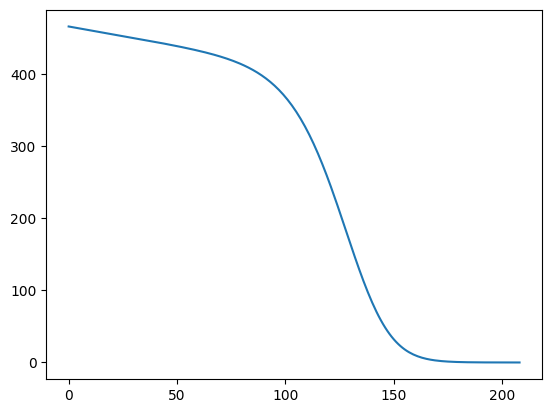

In [3]:
plt.plot(losses)
plt.show()

In [38]:
%autoreload 2

import simple_nn as nn

x_train = np.array([[1]])
y_train = np.array([[10]])

model = nn.Sequential([
    nn.LinearLayer(1, 2),
    nn.LeakyRelu(),
    nn.LinearLayer(2, 1),
    nn.LeakyRelu(),
])

loss_fn = nn.MSELoss()

losses = []
lr = 1e-3
for n in range(1000):
    y_hat = model(x_train)

    loss = loss_fn.forward(y_hat, y_train)
    losses.append(loss)
    if n%100 == 0:
        print(f'\n{n}: {loss=}')
    if abs(loss) < 0.01:
        break
    
    delta = loss_fn.backward()
    model.backward(delta)
    model.update_params(lr)
    

print(f'\n{n}: {loss=}')
print(model.forward(x_train))


0: loss=100.15753610377136

95: loss=0.009091813833258572
[[9.904649]]


[autoreload of simple_nn failed: Traceback (most recent call last):
  File "/Users/david.byttow/Library/Caches/pypoetry/virtualenvs/sandbox-ai-hXSoHufX-py3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/Users/david.byttow/Library/Caches/pypoetry/virtualenvs/sandbox-ai-hXSoHufX-py3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/david.byttow/Library/Caches/pypoetry/virtualenvs/sandbox-ai-hXSoHufX-py3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/Users/david.byttow/Library/Caches/pypoetry/virtualenvs/sandbox-ai-hXSoHufX-py3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    if update_generic(old_obj, new_obj):
  File "/Users/david.byttow/Library/Caches/pypoetry/virtualenvs/sandbox-ai

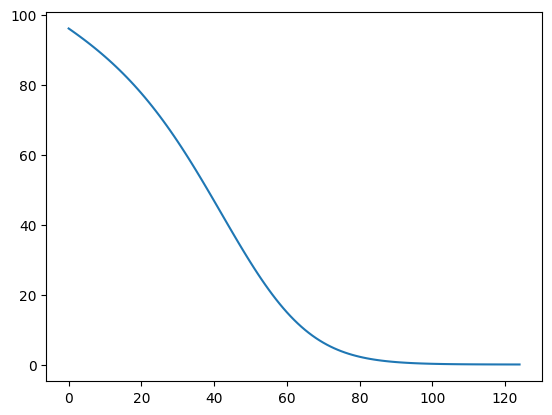

In [27]:
plt.plot(losses)
plt.show()